In [1]:
import os
import json
import numpy as np
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

In [2]:
modes = ["dev", "test", "train"]
base_dir = "json_saved_data"
directories = []
for m in modes:
    directories = directories + [(f"./{base_dir}/{m}/{d}", m) for d in os.listdir(f"{base_dir}/{m}/")]
f"Found {len(directories)} directories"

'Found 4 directories'

In [3]:
directories = directories[:]
directories = sorted(directories, key=lambda x:x[0])
idx = 0
len(directories)

4

In [7]:
def load_data(directory, mode):
    main_file = f"return_dict.json"
    with open(os.path.join(directory, main_file), 'r') as f:
        ret_data = json.load(f)
    for k, v in ret_data.items():
        if k == "data":
            for i, d in enumerate(v):
                if type(d) is str and len(d) > 4 and d[-4:] == ".npy":
                    filename = os.path.join(d)
                    ret_data[k][i] = np.load(filename)
        elif type(v) is str and len(v) > 4 and v[-4:] == ".npy":
            filename = os.path.join(v)
            ret_data[k] = np.load(filename)
    ret_data["mode"] = mode
    return ret_data
ret_data = [load_data(d, m) for d, m in directories]

In [8]:
def print_dict(pdict, margin=2):
    l = max(len(str(k)) for k in pdict) + margin
    for k, v in pdict.items():
        print((str(k) + ":").ljust(l) + str(v))

In [9]:
def get_info(data_item):
    info_dict = {}
    
    shape_keys = ['framewise_features', 'visual_features', 'conv_logits', 'sequence_logits']
    for key in shape_keys:
        info_dict[key + " shape"] = data_item[key].shape
    
    data_keys = ['feat_len', 'loss_LiftPool_u', 'loss_LiftPool_p']    
    for key in data_keys:
        info_dict[key] = data_item[key]
        
    info_dict["video shape"] = data_item["data"][0].shape
    info_dict["video lgt"] = data_item["data"][1]
    info_dict["labels"] = data_item["data"][2]
    info_dict["labels lgt"] = data_item["data"][3]
    
    anotation_data = data_item["data"][-1][0].split("|")
    info_dict["frames"] = len(os.listdir(
        f"./dataset/PHOENIX-2014-T/features/fullFrame-256x256px/{data_item['mode']}/{anotation_data[0]}"))
    info_dict["predicted"] = ' '.join([w for w, n in data_item["recognized_sents"][0]])
    info_dict["gloss truth"] = anotation_data[-2]
    info_dict["german truth"] = anotation_data[-1]
    
    return info_dict

print_dict(get_info(ret_data[idx]))

framewise_features shape: (1, 512, 116)
visual_features shape:    (26, 1, 1024)
conv_logits shape:        (26, 1, 1116)
sequence_logits shape:    (26, 1, 1116)
feat_len:                 [26]
loss_LiftPool_u:          181.86612
loss_LiftPool_p:          225.44742
video shape:              (1, 116, 3, 224, 224)
video lgt:                [26]
labels:                   [521 129 720 603 530 792 720]
labels lgt:               [7]
frames:                   103
predicted:                MORGEN BISSCHEN SCHNEE NORDOST MEHR SCHNEE
gloss truth:              MAL BISSCHEN SCHNEE NORD MEHR STARK SCHNEE
german truth:             gelegentlich schneit es leicht richtung nordosten kann es auch noch kräftiger schneien


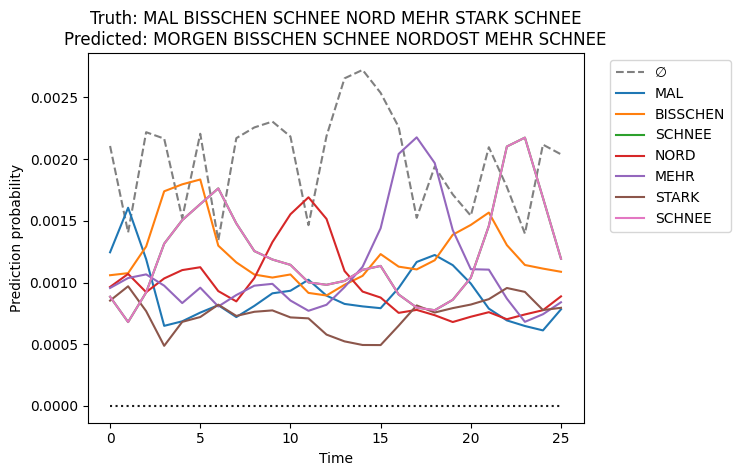

In [10]:
def plot_data(data_item, normalize=True, key='sequence_logits', show_other_labels=False):
    output_data = data_item[key][:, 0, :]
    if normalize:
        output_data = output_data - np.min(output_data)
        output_sum = np.sum(output_data, axis=1)
        output_data = output_data / output_sum.reshape((len(output_sum), 1))
    labels = data_item['data'][2]    
    anotation_data = data_item["data"][-1][0].split("|")
    labels_gloss = anotation_data[-2].split(' ')
    predicted = ' '.join([w for w, n in data_item["recognized_sents"][0]])
    
    plt.plot(output_data[:, 0], '--', color="grey")
    plt.plot(output_data[:, labels])
    if show_other_labels:
        plt.plot(output_data, color=(.3,.3,.3,.1))
    plt.plot((0, output_data.shape[0]-1), (0, 0), ':', color=(.1,.1,.1))
    
    plt.title(f"Truth: {anotation_data[-2]}\nPredicted: {predicted}")
    plt.legend(['∅'] + labels_gloss, bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xlabel('Time')
    plt.ylabel('Prediction probability')
    plt.show()
    
plot_data(ret_data[idx])

array([1. , 2. , 1.2])